# Inflation Forecast
Evidence suggests that the processes producing inflation change over time. The data relevant to determine the inflation rate during recessions may not be influential during growth periods. That is, the model might change with Business Cycles. It is not straightforward to identify at which point of a cycle the economy is currently on, which hinders the performance of structural approaches. And also increases the time necessary to train data-driven multivariate models. Thus, an univariate, nonlinear model seems to be a good starting point.

Long Short-Term Memory (LSTM) is a Recurrent Neural Network (RNN) designed to learn long sequences o data. It does not rely on pre-specified structures or windows - a good fit for forecasting time series.
The project is [here](https://github.com/olavopoletti/Inflation_Forecast.git).


In [ ]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import os.path
from pathlib import Path
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential, save_model, load_model, model_from_json
from keras.layers import Dense, LSTM
from math import sqrt
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error

In [3]:
# Basic layout for the graphics
layout = go.Layout(
    font_family="Segoe UI",
    font_color="Black",
    font_size=14,
    title_font_family="Segoe UI",
    title_font_color="#A79AFF",
    title_font_size=18,
    showlegend=False,
    margin=dict(b = 10,l= 20,r=10,t=50),
    xaxis=dict(
        showgrid=False,
        gridcolor='DarkGrey',
        zeroline=False,
        zerolinecolor='White',
        zerolinewidth=2,
        showticklabels=True,
        ),
    yaxis=dict(
        showgrid=True,
        gridcolor='White',
        zeroline=True,
        zerolinecolor='White',
        zerolinewidth=2,
        showticklabels=True
        ),
    plot_bgcolor='#E3DDD5',
    paper_bgcolor='#FEFBEA',
    autosize=True
    )

## Data
We are using monthly percentage variations on the Broad National Consumer Price Index available (IPCA) at [BACEN](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries). Let's create a Pandas data frame with data; it will make it easier for us to access the data in the format we need.

In [4]:
# Data Frame
df = pd.read_csv(r"monthlyInflation.csv", sep=";")
df = df.rename(
        columns={
                "433 - Broad National Consumer" \
                + " Price Index (IPCA) - Monthly % var.": "IPCA"
                }
        )

# Formatting
df = df[df.Date != "Source"]
df["Date"] = df.Date.astype("datetime64[ns]")
df["IPCA" ] = df["IPCA" ].astype("float")
df = df.set_index('Date')

df.head()

,IPCA
Date,
1980-01-01,6.62
1980-02-01,4.62
1980-03-01,6.04
1980-04-01,5.29
1980-05-01,5.70


Decomposing the series into its components - Trend, Season, and Residual - gives a better understanding of the data.

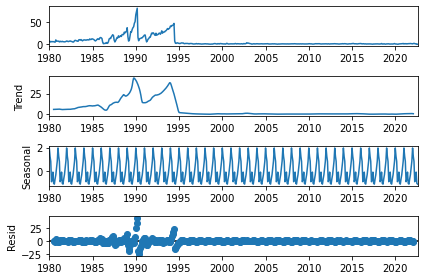

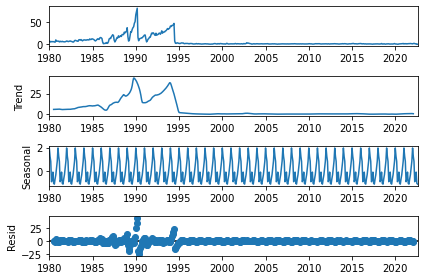

In [5]:
# Decomposing the time series
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()

There is a sharp contrast between the values before and after the 'Real Plan.' Let's check how the series behave before and after July 1994 separately.

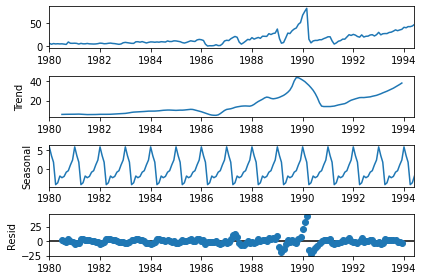

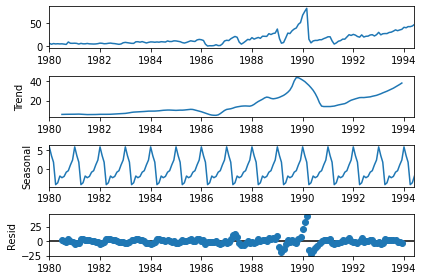

In [6]:
# Decomposition prior to July 1994
decomposition_b = seasonal_decompose(
    df[df.index < '1994-07-01'],
    model='additive'
    )
decomposition_b.plot()

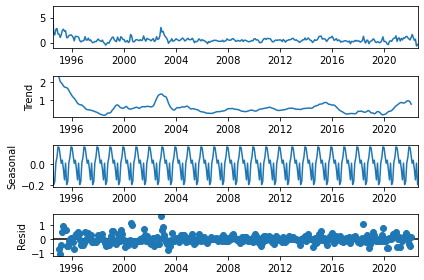

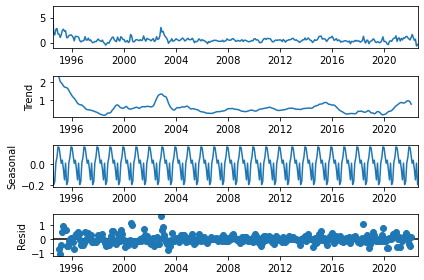

In [7]:
# Decomposition for data after the 'Real Plan'
decomposition_a = seasonal_decompose(
    df[df.index >= '1994-07-01'],
    model='additive'
    )
decomposition_a.plot()

We can see changes in the trend and the cycles - besides the magnitude of the value. It suggests that the new plan produced fundamental changes in inflation behavior. Therefore, considering data before the stabilization program would create a model with characteristics that no longer reflect the current structure of the Brazilian economy. Since economic policy takes some time to be effective, it is worthwhile considering some buffer periods.

In [8]:
# Filter the dataset to exclude data prior to the 'Real Plan'
df = df[df.index >= '1995-01-01']
df.head()

,IPCA
Date,
1995-01-01,1.70
1995-02-01,1.02
1995-03-01,1.55
1995-04-01,2.43
1995-05-01,2.67


Timeseries analysis depends on stationarity, so let's check for it.

In [9]:
# Checking for Stationarity using Augmented Dickey–Fuller test
def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        if result[1] > 0.01:
            print("Series is not stationary")
        else:
            print("Series is stationary")

adf_test(df)

ADF Statistic: -4.856670
p-value: 0.000042
	1%: -3.451
Series is stationary
	5%: -2.871
Series is stationary
	10%: -2.572
Series is stationary


Knowing that the series is stationary, we need to relate each value to its predecessors - we are trying to find how past inflation affects current and future inflation.

In [10]:
# Adding lags to the data. We are considering up to 60 periods prior to the target
col_names = ["T-{}".format(i) for i in range(1, 61)] + ["IPCA"]
def time_steps(data, lag):
	df_temp = data
	columns = [df_temp.shift(i) for i in range(1, lag+1)]
	columns.append(df_temp)
	df_temp = pd.concat(columns, axis=1)
	df_temp.fillna(0, inplace=True)
	df_temp = df_temp.set_axis(col_names, axis=1, inplace=False)
	return df_temp

df_lags = time_steps(df, 60)
df_lags.head()

,T-1,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9,T-10,...,T-52,T-53,T-54,T-55,T-56,T-57,T-58,T-59,T-60,IPCA
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.70
1995-02-01,1.70,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.02
1995-03-01,1.02,1.70,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.55
1995-04-01,1.55,1.02,1.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.43
1995-05-01,2.43,1.55,1.02,1.7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.67


Now we can separate the data into two sets: one for training the model and the other for testing it.

In [11]:
# Train and test data frames - with the last three years as test
train = df_lags[df_lags.index <= '2019-08-01'].values
test = df_lags[df_lags.index > '2019-08-01'].values

In [12]:
# Scaling the data do match the possible outputs of the activation function.
"""
Since we are using a Hyperbolic Tangent, the data will be scaled to be 
between -1 and 1. The scale will be calculated on the training dataset to
avoiding biasing de model
"""

# Set up the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train.reshape(-1,1))

# Adjust the shape of the data
train = train.reshape(train.shape[0], train.shape[1])
test = test.reshape(test.shape[0], test.shape[1])

# Transform the data
train_scaled = scaler.transform(train.reshape(-1,1))
test_scaled = scaler.transform(test.reshape(-1,1))


In [13]:
train_scaled = np.reshape(
    train_scaled,
    (train.shape[0], train.shape[1], -1)
    )
test_scaled = np.reshape(
    test_scaled,
    (test.shape[0], test.shape[1], -1)
    )

In [14]:
# Predictors and target for the training set
train_x, train_y = train_scaled[:, 0:-1], train_scaled[:, -1]

print(train_x.shape)
print(train_y.shape)

(296, 60, 1)
(296, 1)


## The Model

After pre-processing, we are ready to build the model.

In [15]:
# The base model
model = Sequential()

# Number of patters to be processed before updating weights
batch_size = 1

# Number of neurons
neurons = 360

# Number of epochs
epochs = 720

# The LSTM input layer
model.add(
      LSTM(
            neurons,
            input_shape=(60, 1),
            #return_sequences=True,
            )
      )

# The output layer
model.add(Dense(1))

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
      #run_eagerly=True
      )

In [15]:
# Training the model
fit = model.fit(
    train_x,
    train_y,
    validation_data=(train_x, train_y),
    epochs=epochs, 
    batch_size=batch_size,
    verbose=0,
    shuffle=False,
    )

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 360)               521280    
_________________________________________________________________
dense (Dense)                (None, 1)                 361       
Total params: 521,641
Trainable params: 521,641
Non-trainable params: 0
_________________________________________________________________


<function matplotlib.pyplot.show(close=None, block=None)>

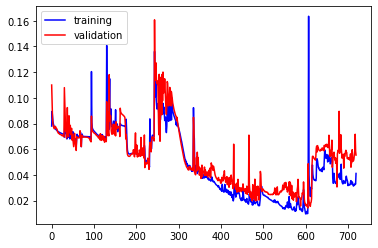

In [17]:
# Check for overfitting
plt.plot(fit.history['loss'], label='training', color='Blue')
plt.plot(fit.history['val_loss'], label='validation',color='Red')
plt.legend()
plt.show

## Performance

In [17]:
# Predictors and target for the testing set
test_x, test_y = test_scaled[:, 0:-1], test_scaled[:, -1]

In [18]:
# Build up state for forecasting
train_pred = model.predict(train_x)

10/10 [==============================] - 3s 147ms/step


In [19]:
test_x[1]

array([[-0.73371105],
       [-0.64872521],
       [-0.60339943],
       [-0.70538244],
       [-0.63739377],
       [-0.38810198],
       [-0.28611898],
       [-0.4674221 ],
       [-0.52974504],
       [-0.62606232],
       [-0.83002833],
       [-0.45609065],
       [-0.43909348],
       [-0.76203966],
       [-0.52407932],
       [ 0.00283286],
       [-0.48441926],
       [-0.58640227],
       [-0.66005666],
       [-0.52974504],
       [-0.54674221],
       [-0.46175637],
       [-0.55240793],
       [-0.47308782],
       [-0.6203966 ],
       [-0.60339943],
       [-0.57507082],
       [-0.84135977],
       [-0.53541076],
       [-0.63172805],
       [-0.5694051 ],
       [-0.52407932],
       [-0.49575071],
       [-0.54107649],
       [-0.60906516],
       [-0.56373938],
       [-0.66572238],
       [-0.46175637],
       [-0.41643059],
       [-0.51274788],
       [-0.26912181],
       [-0.36543909],
       [-0.4674221 ],
       [-0.20113314],
       [ 0.00849858],
       [-0

In [20]:
# Walk-forward validation - one-step window 
predictions = list()
for i in range(0, test_scaled.shape[0]):
	y_hat = model.predict(test_x[i].reshape((1,60,1)))
	predictions.extend(y_hat[0])

test_pred = np.array(predictions)

1/1 [==============================] - 0s 62ms/step


In [22]:
# Convert the predictions back to the original scale
y_test_hat = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
y_test = scaler.inverse_transform(test_y.reshape(-1,1))
y_train_hat = scaler.inverse_transform(train_pred.reshape(-1,1))
y_train = scaler.inverse_transform(train_y.reshape(-1,1))

In [23]:
y_test_hat

array([[ 0.07728643],
       [-0.02353588],
       [ 0.1312501 ],
       [ 0.28534722],
       [ 0.6047466 ],
       [-0.5787726 ],
       [-0.03170852],
       [-0.0066968 ],
       [-0.17141336],
       [-0.12119761],
       [ 0.30848846],
       [ 0.17251936],
       [ 0.0939109 ],
       [ 0.72050744],
       [ 0.65432996],
       [ 0.68684614],
       [ 1.5724452 ],
       [-0.7790298 ],
       [ 0.89023036],
       [ 0.9201323 ],
       [-0.29662997],
       [ 0.75959593],
       [ 0.7071178 ],
       [ 0.69912237],
       [ 0.8244861 ],
       [ 1.5997105 ],
       [ 1.8456874 ],
       [ 1.1043459 ],
       [ 0.82287633],
       [ 0.67386156],
       [ 0.8150118 ],
       [ 0.8934234 ],
       [ 0.67041945],
       [ 0.4051796 ],
       [ 0.6063572 ],
       [-0.5217351 ]], dtype=float32)

In [24]:
# Performance as measured by the Root Mean Squared Error
train_score = mean_squared_error(y_train, y_train_hat[:,0])
print('Train Score: %.2f MSE' % (train_score))
test_score = mean_squared_error(y_test, y_test_hat[:,0])
print('Test Score: %.2f MSE' % (test_score))

model_error = y_test - y_test_hat[:,0]
print('Mean Model Error: ', model_error.mean())

trace_1 = go.Scatter(
    x=df_lags[df_lags.index>'2019-08-01'].index,
    y=df_lags[df_lags.index>'2019-08-01']['IPCA'].values,
    name='Actual',
    marker=dict(color='SteelBlue')
    )

trace_2 = go.Scatter(
    x=df_lags[df_lags.index>'2019-08-01'].index,
    y=y_test_hat.reshape(y_test_hat.shape[0]),
    name='Predicted',
    marker=dict(color='Firebrick')
    )

fig_1 = make_subplots(specs=[[{"secondary_y": False}]])
fig_1.add_trace(trace_1)
fig_1.add_trace(trace_2,secondary_y=False)
fig_1['layout'].update(
    height=600,
    width=800,
    title='Actual vs Predicted',
    xaxis=dict(tickangle=-90),
    showlegend=True,
    )

iplot(fig_1)

Train Score: 0.17 MSE
Test Score: 0.36 MSE
Mean Model Error:  0.08626344288751071


If the model's performance is where we need it to be, we can save the trained model.

## Save the Model

In [ ]:
# Serialize model to JSON
model_json = model.to_json()
with open("{}_neurons_{}_.json".format(neurons, epochs), "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Serialize weights to HDF5
model.save_weights("{}_neurons_{}_.h5".format(neurons, epochs))

In [28]:
# Folder to save the model
save_dir = r'./{}_neurons_{}_epochs'.format(neurons, epochs)

# check if the folder already exists before creating it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    save_dir = r'./{}'.format(input())
    os.makedirs(save_dir)
    
# Save the entire model as a SavedModel.
model.save(save_dir+'/saved_model')

AttributeError: '_UserObject' object has no attribute 'save'

## Forecasting

In [ ]:
# Load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("model.h5")

loaded_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
      #run_eagerly=True
      )

In [ ]:
loaded_model.summary()

In [ ]:
# Load the model
model = load_model(model_file, compile=True)

In [ ]:
# Preprocessing the input for the first period forecast
dataset = df_lags.drop(columns=['T-1'])
x_input = dataset.tail(1).values
x_input = scaler.transform(x_input.reshape(-1,1))

In [ ]:
# Walk-forward forecast - one-step window - for the next 36 months 
for i in range(0, 36):
    x = x_input[-60:].reshape((1, 60, 1))
    output = model.predict(x)[0][0]
    x_input = np.append(x_input, [output])

In [ ]:
# Reverse the scale
input = scaler.inverse_transform(x_input.reshape(-1,1))

In [ ]:
# Consolidate the data
df_pred = pd.DataFrame(
    input[-36:],
    columns=['IPCA'],
    index=pd.date_range('2022-09-01', periods=36, freq='M')
    )

forecast = pd.concat([df, df_pred], ignore_index=False)

forecast

In [ ]:
# The curves
trace_2_1 = go.Scatter(
    x=df[df.index>='2018-01-01'].index,
    y=df.IPCA.values,
    name='Actual',
    marker=dict(color='SteelBlue')
    )

trace_2_2 = go.Scatter(
    x=df_pred.index,
    y=df_pred.IPCA.values,
    name='Forecast',
    marker=dict(color='Firebrick')
    )

fig_2 = make_subplots(specs=[[{"secondary_y": False}]])
fig_2.add_trace(trace_2_1)
fig_2.add_trace(trace_2_2,secondary_y=False)
fig_2['layout'].update(
    height=600,
    width=800,
    title='Actual vs Forecast',
    xaxis=dict(tickangle=-90)
    )

iplot(fig_2)

In [ ]:
# Using interpolation to convert the monthly data into daily samples
daily_forecast = forecast.resample('D').interpolate()
daily_forecast

In [ ]:
# Daily Inflation Curve
trace_3_1 = go.Scatter(
    x=daily_forecast[(daily_forecast.index>'2010-01-01')
                    & (daily_forecast.index<'2022-09-01')].index,
    y=daily_forecast[(daily_forecast.index>'2010-01-01')
                    & (daily_forecast.index<'2022-09-01')].IPCA.values,
    name='Actual',
    marker=dict(color='SteelBlue'),
                    )

trace_3_2 = go.Scatter(
    x=daily_forecast[daily_forecast.index>='2022-09-01'].index,
    y=daily_forecast[daily_forecast.index>='2022-09-01'].IPCA.values,
    name='Forecast',
    marker=dict(color='Firebrick'),
    )

fig_3 = make_subplots(specs=[[{"secondary_y": False}]])
fig_3.add_trace(trace_3_1)
fig_3.add_trace(trace_3_2,secondary_y=False)
fig_3.update(layout=layout,)
fig_3['layout'].update(
    height=800,
    width=1000,
    title='Daily Inflation Curve',
    xaxis=dict(tickangle=-90)
    )

iplot(fig_3)

Finally, we save the forecast as a Excel table to share and feed into other analysis. 

In [ ]:
# Save a table
daily_forecast.to_excel(r'daily_inflation.xlsx')

## References
Almosova, A., & Andresen, N. (2019). Nonlinear Inflation Forecasting with Recurrent Neural Networks.  
Brownlee, J. (2017, April 7). Re: Time Series Forecasting with the Long Short-Term Memory Network in Python. Machine Learning Mastery. https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/  
Chakraborty, C., & Joseph, A. (2017). Machine learning at central banks.  
Garcia, M. G., Medeiros, M. C., & Vasconcelos, G. F. (2017). Real-time inflation forecasting with high-dimensional models: The case of Brazil. International Journal of Forecasting, 33(3), 679-693.  
Lazzeri, F. (2020). Machine learning for time series forecasting with Python. John Wiley & Sons.  
Medeiros, M. C., Vasconcelos, G. F., Veiga, Á., & Zilberman, E. (2021). Forecasting inflation in a data-rich environment: the benefits of machine learning methods. Journal of Business & Economic Statistics, 39(1), 98-119.  
Paranhos, L. (2021). Predicting inflation with neural networks. arXiv preprint arXiv:2104.03757.  
Schelter, B., Winterhalder, M., & Timmer, J. (2006). Handbook of time series analysis. Wiley-VCH, Berlin.  

